In [1]:
import ee
import pandas as pd
import numpy as np
from pprint import pprint
import matplotlib.pyplot as plt
import geemap
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics

In C:\Users\wangj\Anaconda3\envs\ee_py3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\wangj\Anaconda3\envs\ee_py3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\wangj\Anaconda3\envs\ee_py3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In C:\Users\wangj\Anaconda3\envs\ee_py3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\wangj\Anaconda3\envs\ee_py3\lib\

In [2]:
ee.Initialize()

In [3]:
# define a limite condition that only analyse part of the data
limit_list = [0,1,4]

### define parameters

In [4]:
# import urban-img and terrain data
urban = ee.Image("users/wangjinzhulala/North_China_Plain_Python/classificatioin_temporal_checked/Mosaic_only_forward")
region = ee.FeatureCollection("users/wangjinzhulala/North_China_Plain_Python/Boundary_shp/North_China_Plain_Boundary")

In [5]:
# define the year-range
year = [f'{i}_{i+2}' for i in range(1990,2020,3)]
year_img_val_dict = {yr:i for yr,i in zip(year,range(10,0,-1))}

In [6]:
# get all possible years for traning the projection
proj_yr = []
for k,v in year_img_val_dict.items():
    # get the t0 val/img
    t0 = k
        
    # get the t1;t2
    if v == 2:
        pass
    else:
        for val in range(v-1,1,-1):
            prj_val = val - (v - val)
            
            if  prj_val>0:
                
                prj_yr  = [k for k,v in year_img_val_dict.items() if v==prj_val][0]
                
                t1 = [k for k,v in year_img_val_dict.items() if v==val][0]
                t2 = [k for k,v in year_img_val_dict.items() if v==prj_val][0]
                                
                proj_yr.append((t0,t1,t2))

In [7]:
proj_yr

[('1990_1992', '1993_1995', '1996_1998'),
 ('1990_1992', '1996_1998', '2002_2004'),
 ('1990_1992', '1999_2001', '2008_2010'),
 ('1990_1992', '2002_2004', '2014_2016'),
 ('1993_1995', '1996_1998', '1999_2001'),
 ('1993_1995', '1999_2001', '2005_2007'),
 ('1993_1995', '2002_2004', '2011_2013'),
 ('1993_1995', '2005_2007', '2017_2019'),
 ('1996_1998', '1999_2001', '2002_2004'),
 ('1996_1998', '2002_2004', '2008_2010'),
 ('1996_1998', '2005_2007', '2014_2016'),
 ('1999_2001', '2002_2004', '2005_2007'),
 ('1999_2001', '2005_2007', '2011_2013'),
 ('1999_2001', '2008_2010', '2017_2019'),
 ('2002_2004', '2005_2007', '2008_2010'),
 ('2002_2004', '2008_2010', '2014_2016'),
 ('2005_2007', '2008_2010', '2011_2013'),
 ('2005_2007', '2011_2013', '2017_2019'),
 ('2008_2010', '2011_2013', '2014_2016'),
 ('2011_2013', '2014_2016', '2017_2019')]

### Rearrange the dfs, and intopolate the df to make every value to be contineous

In [10]:
# a helper function to create remapp list pairs
def create_remap_img(img,df):
    
    # instantiate a stadardize scaler
    scaler = MinMaxScaler()

    # create a trans_val whcih holds the standardized val
    df['trans_val'] = scaler.fit_transform(np.array(df['count']).reshape(-1,1))

    # get min-max from index for later interpolate
    max_val = df['original_val'].max()
    min_val = df['original_val'].min()
    range_val = range(min_val,max_val+1,1)

    # create a df according to the min-max
    df_range = pd.DataFrame(list(range_val),columns = ['from'])

    # join the df to df_range, and then intoporlate the values
    df_merge = df_range.merge(df,left_on='from',right_on='original_val',how='left')
    df_interpolate = df_merge.interpolate()
    df_interpolate['to'] = df_interpolate['trans_val'].apply(lambda x: int(x*10000))

    # get the remape list and img
    from_list,to_list = df_interpolate['from'].values.tolist(),df_interpolate['to'].values.tolist()
    remap_img = img.remap(from_list,to_list,0)

    
    return df_interpolate,remap_img

##### Just for test

In [11]:
# function to compute the AUC given pred_image and true_expansion image

def conpute_AUC(pred_img, true_expansion, img_mask):

    # get the true values using pt to extracnt the expansion_prj
    val_true = ee.ImageCollection(true_expansion.updateMask(img_mask))\
                 .getRegion(geometry = pt, scale = 30).getInfo()

    # then retive value from suitability map
    val_prob = ee.ImageCollection(pred_img.updateMask(img_mask))\
                 .getRegion(geometry = pt, scale = 30).getInfo()

    # conver the valut to df
    df_prob = pd.DataFrame(val_prob[1:],columns=val_prob[0])
    df_prob['time'] = 1
    df_prob = df_prob.dropna()

    df_true = pd.DataFrame(val_true[1:],columns=val_true[0])
    df_true['time'] = 1
    df_true = df_true.dropna()

    # merge two df together
    df_merge = pd.merge(df_prob, df_true,  how='inner', left_on=['longitude','latitude'], right_on =['longitude','latitude'])

    # calculate the auc
    col_name = df_prob.columns[-1] 

    y_true = df_merge['pred_validation'].values
    y_prob = df_merge[col_name].values

    fpr, tpr, thresholds = metrics.roc_curve(y_true, y_prob)
    auc = metrics.auc(fpr, tpr)
    
    return auc


In [ ]:
# define a threshold to determint the percentile
pct_threshold = 0.75

training_eval_list = []
criteria = {}

for k,(t0,t1,t2) in enumerate(proj_yr):
    
    if k in limit_list:
        

        
        #________________________________get the Training/Eval metrics____________________________
        
        # get the train-eval metrics
        train_eval_dfs = [pd.read_csv(f'./Result/training_metrics/FCNN_{t0}_and_{t1}_prj_{t2}_{i*10:03}.csv') for i in range(1,11)]
        train_eval_df  = pd.concat(train_eval_dfs).reset_index(drop=True)
        
        # add year info to df
        train_eval_df['t0'] = t0
        train_eval_df['t1'] = t1
        train_eval_df['t2'] = t2
        train_eval_df['epoch'] = train_eval_df.index + 1
        
        # add the df to list
        training_eval_list.append(train_eval_df)
        
        # compute the creteria (percentile) to reduce noise data
        percentile_val = train_eval_df.quantile(pct_threshold)
        criteria[(t0,t1,t2,'loss')] = [percentile_val['loss']]
        criteria[(t0,t1,t2,'val_loss')] = [percentile_val['val_loss']]
        
        
        #__________________________________compute the AUC_________________________________________
        
        # get the urban imgs
        t0_img = urban.gte(year_img_val_dict[t0])
        t1_img = urban.gte(year_img_val_dict[t1])
        t2_img = urban.gte(year_img_val_dict[t2])

        # compute the distance suitability map
        df_distance = pd.read_csv(f'./Result/df_distance_{t0}_and_{t1}_prj_{t2}.csv')
        Distance_t1 = ee.Image(f'users/wangjinzhulala/GEE_TF/Distance_to_urban/Distance_{t1}')
        _, dist_remap = create_remap_img(Distance_t1,df_distance)

        # get the true expansion for calculating the AUC
        expansion_t1_t2 = t2_img.subtract(t1_img).rename('pred_validation')
        
        # prepare img for AUC calculation
        FCNN_prob = [ee.ImageCollection(f"users/wangjinzhulala/GEE_TF/Urban_projection/FCNN_{t0}_and_{t1}_prj_{t2}_no_distance_{i}")\
                       .mosaic()\
                       .divide(10000) for i in range(10,100+1,10)]
        
        all_imgs = FCNN_prob + [dist_remap]

        # prepare names 
        all_names = [f'FCNN_{i}' for i in range(10,100+1,10) ] + ['Distance']
        
        AUC_dict = {}
        # repeate the AUC computation for 10 times to get the confidential-interval
        for i in range(10):
            pt =  ee.FeatureCollection(f"users/wangjinzhulala/GEE_TF/ROC_AUC/random_pt_100k")\
                    .randomColumn(seed =i)\
                    .filterMetadata('random','less_than',0.5)

            for img,name in zip(all_imgs,all_names):
                # get the AUC
                auc = conpute_AUC(img, expansion_t1_t2, t1_img.Not())

                # append auc to dict
                AUC_dict[(t0,t1,t2,name,i)] = [auc]

                # print out the process
                print(f'{t0} and {t1} project {t2}: {name} of {i} has the AUC of {auc}')

1990_1992 and 1993_1995 project 1996_1998: FCNN_10 of 0 has the AUC of 0.9031725459676749
1990_1992 and 1993_1995 project 1996_1998: FCNN_20 of 0 has the AUC of 0.9397492486677695
1990_1992 and 1993_1995 project 1996_1998: FCNN_30 of 0 has the AUC of 0.9384146364096404
1990_1992 and 1993_1995 project 1996_1998: FCNN_40 of 0 has the AUC of 0.9479273870960158
1990_1992 and 1993_1995 project 1996_1998: FCNN_50 of 0 has the AUC of 0.7612402889767901
1990_1992 and 1993_1995 project 1996_1998: FCNN_60 of 0 has the AUC of 0.9478109599854497
1990_1992 and 1993_1995 project 1996_1998: FCNN_70 of 0 has the AUC of 0.9455987830211908
1990_1992 and 1993_1995 project 1996_1998: FCNN_80 of 0 has the AUC of 0.9461347993333589
1990_1992 and 1993_1995 project 1996_1998: FCNN_90 of 0 has the AUC of 0.947997292853157
1990_1992 and 1993_1995 project 1996_1998: FCNN_100 of 0 has the AUC of 0.9463867075130749
1990_1992 and 1993_1995 project 1996_1998: Distance of 0 has the AUC of 0.9331871881872855
1990_1992

In [ ]:
# formating all results to dfs
training_eval_df = pd.concat(training_eval_list).reset_index(drop=True)

criteria_df = pd.DataFrame(criteria).T.reset_index()
criteria_df.columns = ['t0','t1','t2','loss_type','val']
criteria_df

In [151]:
training_eval_rm_noizy = []

for k,(t0,t1,t2) in enumerate(proj_yr):    
    if k in limit_list:
        
        # get the percentile value 
        percentile_train_loss = criteria_df[  (criteria_df['t0'] == t0)
                                            & (criteria_df['t1'] == t1)
                                            & (criteria_df['t2'] == t2)
                                            & (criteria_df['loss_type'] == 'loss')]['val'].values[0]
        
        percentile_validation_loss = criteria_df[  (criteria_df['t0'] == t0)
                                                 & (criteria_df['t1'] == t1)
                                                 & (criteria_df['t2'] == t2)
                                                 & (criteria_df['loss_type'] == 'val_loss')]['val'].values[0]
        
        # use the percentile value to remove nosisy data of training_eval_df
        df_rm_noizy = training_eval_df[ (training_eval_df['t0'] == t0)
                                      & (training_eval_df['t1'] == t1)
                                      & (training_eval_df['t2'] == t2)
                                      & (training_eval_df['loss'] < percentile_train_loss)
                                      & (training_eval_df['val_loss'] < percentile_validation_loss)]
        
        df_rm_noizy['prj_year'] = df_rm_noizy.apply(lambda x: f"{x['t0']}_and_{x['t1']}_prj_{x['t2']}", axis=1) 
        
        # add df to list
        training_eval_rm_noizy.append(df_rm_noizy)

C:\Users\wangj\Anaconda3\envs\ee_py3\lib\site-packages\ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\wangj\Anaconda3\envs\ee_py3\lib\site-packages\ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\wangj\Anaconda3\envs\ee_py3\lib\site-packages\ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

In [154]:
df = pd.concat(training_eval_rm_noizy)
df

,loss,root_mean_squared_error,val_loss,val_root_mean_squared_error,t0,t1,t2,epoch,prj_year
20,0.009391,0.096905,0.009936,0.099678,1990_1992,1993_1995,1996_1998,21,1990_1992_and_1993_1995_prj_1996_1998
23,0.009306,0.096466,0.009466,0.097293,1990_1992,1993_1995,1996_1998,24,1990_1992_and_1993_1995_prj_1996_1998
24,0.009373,0.096813,0.009854,0.099266,1990_1992,1993_1995,1996_1998,25,1990_1992_and_1993_1995_prj_1996_1998
28,0.009356,0.096726,0.009555,0.097749,1990_1992,1993_1995,1996_1998,29,1990_1992_and_1993_1995_prj_1996_1998
29,0.009350,0.096697,0.009737,0.098678,1990_1992,1993_1995,1996_1998,30,1990_1992_and_1993_1995_prj_1996_1998
...,...,...,...,...,...,...,...,...,...
395,0.005059,0.071125,0.006348,0.079674,1993_1995,1996_1998,1999_2001,96,1993_1995_and_1996_1998_prj_1999_2001
396,0.005032,0.070937,0.006473,0.080455,1993_1995,1996_1998,1999_2001,97,1993_1995_and_1996_1998_prj_1999_2001
397,0.004998,0.070699,0.006340,0.079623,1993_1995,1996_1998,1999_2001,98,1993_1995_and_1996_1998_prj_1999_2001
398,0.004962,0.070442,0.006426,0.080162,1993_1995,1996_1998,1999_2001,99,1993_1995_and_1996_1998_prj_1999_2001


<AxesSubplot:xlabel='epoch', ylabel='val_loss'>

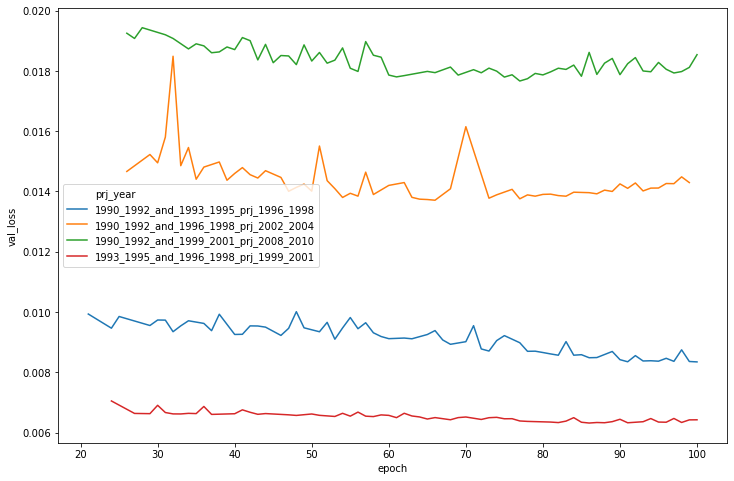

In [156]:
plt.figure(figsize=(12,8))
sns.lineplot(data=df,x='epoch',y='val_loss',hue='prj_year')

<AxesSubplot:>

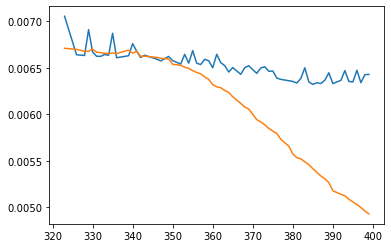

In [128]:
training_eval_rm_noizy['val_loss'].plot()
training_eval_rm_noizy['loss'].plot()

In [30]:
t = pd.DataFrame(AUC_dict).T
t = t.reset_index()
t.columns = ['Name','K','AUC']

<AxesSubplot:xlabel='Name', ylabel='AUC'>

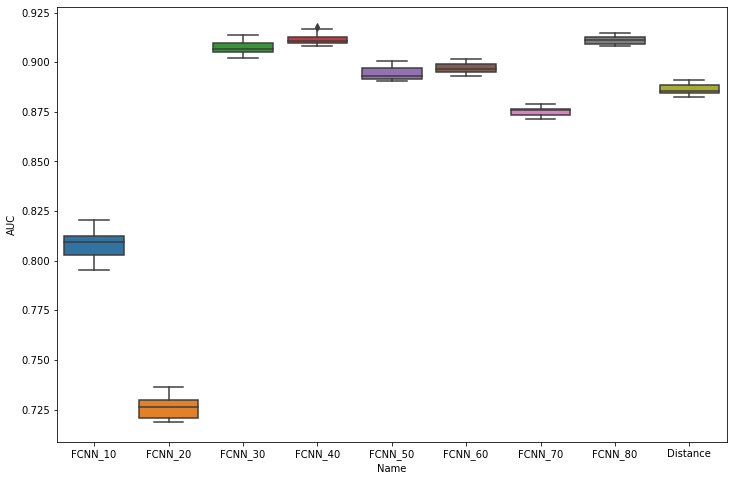

In [32]:
plt.figure(figsize=(12,8))
sns.boxplot(data = t,x='Name',y='AUC')

## Some legacies

In [ ]:
# import the terrain image
DEM = ee.Image("USGS/SRTMGL1_003")
SLOPE = ee.Terrain.slope(DEM).toUint8()

### compute the urban/terrain/distance image

In [ ]:
# # calculate the distance to urban image
# Distance = [img.distance(ee.Kernel.euclidean(200)).toInt() for img in urban_each_year]

# # export the distance img to gee-asset
# for yr,img in zip(year,Distance):
    
#     dist_name = f'Distance_{yr}'
    
#     task = ee.batch.Export.image.toAsset(   image =   img,   
#                                             description=dist_name,
#                                             assetId=f'users/wangjinzhulala/GEE_TF/Distance_to_urban/{dist_name}',
#                                             region=region.geometry(),
#                                             scale=30,    
#                                             maxPixels=int(1e13))
#     task.start()
    
#     print(dist_name)

### compute the urban/terrain/distance image

In [9]:
# # create the training patch

# urban_prj_data = []
# for t in proj_yr:
    
#     # get the time
#     t0 = t[0]
#     t1 = t[1]
#     t2 = t[2]
#     proj_times = year_img_val_dict[t0] - year_img_val_dict[t1]
#     proj_years = proj_times*3
    
#     # get the built-up layer
#     t0_img,t1_img,t2_img = [urban.gte(year_img_val_dict[yr]).rename(f'built_up_t{i}') for i,yr in enumerate(t)]
    
#     # get the expansion mask
#     expansion_mask = t1_img.subtract(t0_img).rename('expansion')
#     expansion_prj  = t2_img.subtract(t1_img).rename('pred_validation')
    
#     # get the distance to built-up layer
#     Distance_t0 = ee.Image(f'users/wangjinzhulala/GEE_TF/Distance_to_urban/Distance_{t0}')
#     Distance_t1 = ee.Image(f'users/wangjinzhulala/GEE_TF/Distance_to_urban/Distance_{t1}')

#     # get the fcnn probability map; Note divede the img by 10000
#     FCNN_prob = ee.ImageCollection(f"users/wangjinzhulala/GEE_TF/Urban_projection/FCNN_{t0}_and_{t1}_prj_{t2}").mosaic().divide(10000)
    
#     # add patch to a dict
#     urban_prj_data.append([t0,t1,t2,t0_img,t1_img,t2_img,proj_times,proj_years,
#                            expansion_mask,expansion_prj,Distance_t0,Distance_t1,FCNN_prob])

In [8]:
# # put all data into a df
# urban_prj_data_df = pd.DataFrame(urban_prj_data,columns = ['t0','t1','t2','t0_img','t1_img','t2_img','proj_times','proj_years',
#                                                            'expansion_mask','expansion_prj','Distance_t0','Distance_t1','FCNN_prob'])
# urban_prj_data_df

### compute the frequency of factors (DEM/SLOPE/Distance) in urban-expansion mask

In [9]:
# for idx,row in urban_prj_data_df.iterrows():
    
#     # get parameters
#     t0,t1,t2 = row['t0'],row['t1'],row['t2']
#     Distance_t0 = row['Distance_t0']
#     expansion_mask = row['expansion_mask']

#     # compute the DEM-frequency
#     freq_DEM = DEM.updateMask(expansion_mask).reduceRegion( reducer=ee.Reducer.frequencyHistogram(),
#                                                   geometry=region.geometry().bounds(),
#                                                   scale=30,
#                                                   maxPixels=int(1e13)) 

#     # compute the SLOPE-frequency
#     freq_SLOPE = SLOPE.updateMask(expansion_mask).reduceRegion( reducer=ee.Reducer.frequencyHistogram(),
#                                                       geometry=region.geometry().bounds(),
#                                                       scale=30,
#                                                       maxPixels=int(1e13))

#     # compute the distance-frequency
#     freq_Distance = Distance_t0.updateMask(expansion_mask).reduceRegion( reducer=ee.Reducer.frequencyHistogram(),
#                                                         geometry=region.geometry().bounds(),
#                                                         scale=30,
#                                                         maxPixels=int(1e13))

#     # get the values from above gee-instance 
#     dict_dem = {int(k):[int(v)] for k,v in freq_DEM.getInfo()['elevation'].items()}
#     dict_slope = {int(k):[int(v)] for k,v in freq_SLOPE.getInfo()['slope'].items()}
#     dict_distance = {int(k):[int(v)] for k,v in freq_Distance.getInfo()['b1'].items()}

#     # conver the values to dfs
#     df_dem = pd.DataFrame(dict_dem).T.sort_index()
#     df_dem.reset_index(inplace=True)
#     df_dem.columns = ['original_val','count']
    
#     df_slope = pd.DataFrame(dict_slope).T.sort_index()
#     df_slope.reset_index(inplace=True)
#     df_slope.columns = ['original_val','count']
    
#     df_distance = pd.DataFrame(dict_distance).T.sort_index()
#     df_distance.reset_index(inplace=True)
#     df_distance.columns = ['original_val','count']

#     # save dfs to disk
#     df_dem.to_csv(f'./Result/df_dem_{t0}_and_{t1}_prj_{t2}.csv',index=False)
#     df_slope.to_csv(f'./Result/df_slope_{t0}_and_{t1}_prj_{t2}.csv',index=False)
#     df_distance.to_csv(f'./Result/df_distance_{t0}_and_{t1}_prj_{t2}.csv',index=False)
    
#     # print out the process
#     print(f'{t0}_and_{t1}_prj_{t2} completed!')

1990_1992_and_1993_1995_prj_1996_1998 completed!
1990_1992_and_1996_1998_prj_2002_2004 completed!
1990_1992_and_1999_2001_prj_2008_2010 completed!
1990_1992_and_2002_2004_prj_2014_2016 completed!
1993_1995_and_1996_1998_prj_1999_2001 completed!
1993_1995_and_1999_2001_prj_2005_2007 completed!
1993_1995_and_2002_2004_prj_2011_2013 completed!
1993_1995_and_2005_2007_prj_2017_2019 completed!
1996_1998_and_1999_2001_prj_2002_2004 completed!
1996_1998_and_2002_2004_prj_2008_2010 completed!
1996_1998_and_2005_2007_prj_2014_2016 completed!
1999_2001_and_2002_2004_prj_2005_2007 completed!
1999_2001_and_2005_2007_prj_2011_2013 completed!
1999_2001_and_2008_2010_prj_2017_2019 completed!
2002_2004_and_2005_2007_prj_2008_2010 completed!
2002_2004_and_2008_2010_prj_2014_2016 completed!
2005_2007_and_2008_2010_prj_2011_2013 completed!
2005_2007_and_2011_2013_prj_2017_2019 completed!
2008_2010_and_2011_2013_prj_2014_2016 completed!
2011_2013_and_2014_2016_prj_2017_2019 completed!


In [ ]:
# for idx,row in urban_prj_data_df.iterrows():
    
#     # get parameters
#     t0,t1,t2 = row['t0'],row['t1'],row['t2']
#     Distance_t1 = row['Distance_t1']
#     t1_img = row['t1_img']
#     expansion_prj = row['expansion_prj']
    
#     # read_dfs
#     df_dem = pd.read_csv(f'./Result/df_dem_{t0}_and_{t1}_prj_{t2}.csv')
#     df_slope = pd.read_csv(f'./Result/df_slope_{t0}_and_{t1}_prj_{t2}.csv')
#     df_distance = pd.read_csv(f'./Result/df_distance_{t0}_and_{t1}_prj_{t2}.csv')

#     # remap the dem/slope/distance accordint to the frequency-df
#     suitability_maps = ee.Image([create_remap_img(img,df)[1].rename(n) for img,df,n in zip((DEM,SLOPE,Distance_t1),
#                                                                                             (df_dem,df_slope,df_distance),
#                                                                                             ('DEM','SLOPE','Distance'))])

#     # create random weight that sums to 100
#     random_wieghts = (np.random.dirichlet(np.ones(3),size=100)*100).astype(int).tolist()

#     # create the random weighted suitability images
#     suitability_merge_map = [suitability_maps.select('DEM').multiply(i)\
#                              .add(suitability_maps.select('SLOPE').multiply(j))\
#                              .add(suitability_maps.select('Distance').multiply(k))\
#                              .divide((i+j+k)*10000)\
#                              .rename(f'DEM_{i:03}_SLOPE_{j:03}_Distance_{k:03}') \
#                              for i,j,k in random_wieghts]
    
#     # get the true values using pt to extracnt the expansion_prj
#     val_true = ee.ImageCollection(expansion_prj.updateMask(t1_img.Not()))\
#                  .getRegion(geometry = pt, scale = 30).getInfo()
    
    
    

#     #_________________________calculate the auc with different factor weights_________________________

#     AUC = {}
#     flag = 0
    
#     # print out the process
#     print(f'____________________{t0}_and_{t1}_prj_{t2}___________________')

#     for i,img in enumerate(suitability_merge_map):

#         # first retive value from suitability map
#         val_prob = ee.ImageCollection(img.updateMask(t1_img.Not()))\
#                      .getRegion( geometry = pt, scale = 30).getInfo()

#         # conver the valut to df
#         df_prob = pd.DataFrame(val_prob[1:],columns=val_prob[0])
#         df_prob['time'] = 1
#         df_prob = df_prob.dropna()

#         df_true = pd.DataFrame(val_true[1:],columns=val_true[0])
#         df_true['time'] = 1
#         df_true = df_true.dropna()

#         # merge two df together
#         df_merge = pd.merge(df_prob, df_true,  how='inner', left_on=['longitude','latitude'], right_on =['longitude','latitude'])

#         # calculate the auc
#         col_name = df_prob.columns[-1] 
#         dem_num = col_name.split('_')[1]
#         slope_num = col_name.split('_')[3]
#         distance_num = col_name.split('_')[5]


#         y_true = df_merge['pred_validation'].values
#         y_prob = df_merge[col_name].values
        
#         fpr, tpr, thresholds = metrics.roc_curve(y_true, y_prob)
#         auc = metrics.auc(fpr, tpr)
#         AUC[dem_num,slope_num,distance_num] = [auc, fpr, tpr, thresholds]

#         # print out the process
#         flag = flag + 1
#         print(f'{col_name} has AUC of {auc:0.3f} {flag}_{len(suitability_merge_map)}')
        
#     #________________________________save result to disk_______________________________
#     auc_df = pd.DataFrame(AUC).T
#     auc_df.reset_index(inplace=True)
#     auc_df.columns = ['DEM','SLOPE','Distance','AUC','fpr', 'tpr', 'thresholds']
#     auc_df.to_csv(f'./Result/AUC_{t0}_and_{t1}_prj_{t2}.csv',index=False)